# script

In [ ]:
pd.set_option('display.max_columns', 999)

In [19]:
%%writefile ../../lendingclub/data_and_eval_preparation/07_create_train_test.py
'''
this makes the train and test sets as well as bootstrapped sets.
trainable loans are loans that are "done" enough
'''
import os
import pickle

import pandas as pd
# testing

from lendingclub import config

dpath = config.data_dir
base_loan_info = pd.read_feather(os.path.join(dpath, 'base_loan_info.fth'))
eval_loan_info = pd.read_feather(os.path.join(dpath, 'eval_loan_info.fth'))
pmt_hist = pd.read_feather(os.path.join(dpath, 'scaled_pmt_hist.fth'))

def check_sample_distribution(df, sample, diff_thrsh=.05, check_cols=[], verbose=True):
    '''
    check if the distribution of the sample's col and df's col is sufficiently
    close. Default tolerance is 1% difference
    '''
    if not check_cols:
        check_cols = df.columns
    pop_n = len(df)
    s_n = len(sample)
    sample_miss = {}
    big_pct_diff = {}
    for col in check_cols:
        pop_group = df[col].value_counts(dropna=False)/pop_n
        s_group = sample[col].value_counts(dropna=False)/s_n
        temp_miss = {}
        temp_diff = {}
        for k in pop_group.keys():
            if k not in s_group.keys():
                if verbose:
                    print('{0} group for {2} column is missing entirely from the sample \
                      while population has {1}'.format(k, pop_group[k], col))
                temp_miss[k] = pop_group[k]
            else:
                pct_diff = abs(pop_group[k] - s_group[k])/pop_group[k]
                if pct_diff > diff_thrsh:
                    temp_diff[k] = pct_diff
        if temp_miss:
            sample_miss[col] = temp_miss
        if temp_diff:
            big_pct_diff[col] = temp_diff
    if sample_miss or big_pct_diff:
        print("There is a sampling concern")

def check_not_same_loans(tr, te):
    return bool(len(set(tr['id']).intersection(set(te['id']))) == 0)

def check_all_loans_accounted(tr, te, to):
    return bool(tr.shape[0] + te.shape[0] == to.shape[0])

def check_same_n_instances(df1, df2):
    return bool(df1.shape[0] == df2.shape[0])

def check_same_n_cols(df1, df2):
    return bool(df1.shape[1] == df2.shape[1])

def check_train_test_testable(train, test, testable, train1, test1, testable1):
    '''
    First set for loan_info, second set for eval_loan_info
    '''
    print(train.shape, test.shape, testable.shape, train1.shape, test1.shape, testable1.shape)
    assert check_not_same_loans(train, test)
    assert check_all_loans_accounted(train, test, testable)
    assert check_not_same_loans(train1, test1)
    assert check_all_loans_accounted(train1, test1, testable1)
    assert check_same_n_instances(train, train1)
    assert check_same_n_instances(test, test1)
    assert check_same_n_instances(testable, testable1)
    assert check_same_n_cols(train, test)
    assert check_same_n_cols(train1, test1)
    return True

#from 2010-1-1 onward, take out min(10%, 2000) loans to set aside as train
doneness = .95
train_testable_eval_loan_info = eval_loan_info.query('maturity_time_stat_adj >= @doneness or maturity_paid_stat_adj >= @doneness')
train_testable_ids = train_testable_eval_loan_info['id']
train_testable_loan_info = base_loan_info.query('id in @train_testable_ids')

assert train_testable_eval_loan_info.shape[0] == train_testable_loan_info.shape[0]

# save loans useable for training and testing
train_testable_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_testable_eval_loan_info.fth'))
train_testable_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_testable_base_loan_info.fth'))

issue_d_g = train_testable_eval_loan_info.groupby('issue_d')
test_ids = []
check_cols = ['target_strict', 'grade']
for date, group in issue_d_g:
    if date >= pd.to_datetime('2010-1-1'):
        print('sampling {0} for issue_d group {1}'.format(min(int(len(group)*.1), 2000), date))
        samp = group.sample(n=min(int(len(group)*.1), 2000), random_state=42)
        if check_sample_distribution(group, samp, check_cols=check_cols, verbose=False):
            print()
        test_ids.extend(samp['id'].tolist())

test_eval_loan_info = train_testable_eval_loan_info.query('id in @test_ids')
test_loan_info = train_testable_loan_info.query('id in @test_ids')

train_eval_loan_info = train_testable_eval_loan_info.query('id not in @test_ids')
train_loan_info = train_testable_loan_info.query('id not in @test_ids')

if check_train_test_testable(train_eval_loan_info, test_eval_loan_info, train_testable_eval_loan_info,
                             train_loan_info, test_loan_info, train_testable_loan_info):
    # save
    test_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'test_eval_loan_info.fth'))
    test_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'test_base_loan_info.fth'))
    train_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_eval_loan_info.fth'))
    train_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_base_loan_info.fth'))

    # make 10 bootstrap month-by-month test_loan_infos (and maybe test_eval_loan_infos?)
    bootstrap_sample_ids = {}
    issue_d_g = test_eval_loan_info.groupby('issue_d')
    for i in range(10):
        to_concat = []
        for d, g in issue_d_g:
            to_concat.append(g.sample(len(g), replace=True))
        df = pd.concat(to_concat)
#         df.reset_index(drop=True).to_feather(os.path.join(dpath, 'test_eval_loan_info_{0}_bootstrap.fth'.format(i)))
        bootstrap_sample_ids[i] = df['id'].tolist()
    
    with open(os.path.join(dpath, 'bootstrap_test_eval_loan_info_ids.pkl'), 'wb') as file:
        pickle.dump(bootstrap_sample_ids, file)

Overwriting ../../lendingclub/data_and_eval_preparation/07_create_train_test.py


In [9]:
df = pd.DataFrame({'a': [1,2,3,10], 'b': [4,5,6,20]})
df

,a,b
0,1,4
1,2,5
2,3,6
3,10,20


In [18]:
df.sample(2, random_state=42)

,a,b
1,2,5
3,10,20


# check sampling idea. does sample size n relative to population size p cause sampling problems in terms of distribution?

In [5]:
test = eval_loan_info[['target_strict', 'grade']]

In [8]:
df = pd.concat([test]*100)

In [10]:
df['target_strict'].mean()

0.15526552655265527

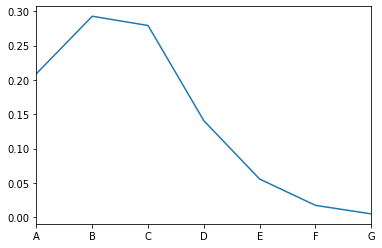

In [23]:
(df['grade'].value_counts(dropna=False)/len(df)).sort_index().plot()

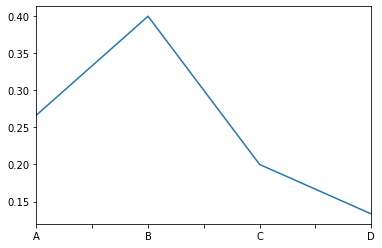

In [61]:
sample_size = 30
(df.sample(sample_size)['grade'].value_counts(dropna=False)/(sample_size)).sort_index().plot()

In [63]:
(df.sample(sample_size)['grade'].value_counts(dropna=False)/(sample_size)).keys()

Index(['B', 'C', 'D', 'A', 'G'], dtype='object')

# script again

In [10]:
eval_loan_info.head()

,end_d,issue_d,maturity_paid,maturity_time,maturity_time_stat_adj,maturity_paid_stat_adj,rem_to_be_paid,roi_simple,target_loose,target_strict,loan_status,id,grade,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35
0,2012-11-01,2009-11-01,1.000000,1.0,1.0,1.0,0.000000,1.222941,0,0,paid,57416,C,0.135866,0.118989,0.102459,0.086267,0.070405,0.054865,0.039640,0.024723,0.010105,-0.004219,-0.018257,-0.032016,-0.045502,-0.058721,-0.071679,-0.084383,-0.096838,-0.109050,-0.121025,-0.132768,-0.144285,-0.155580,-0.166658,-0.177525,-0.188186,-0.198644,-0.208904,-0.218972,-0.228851,-0.238545,-0.248059
1,2009-11-01,2007-11-01,0.509957,1.0,1.0,1.0,6498.933594,0.645634,1,1,charged_off,145926,E,-0.380326,-0.385478,-0.390568,-0.395598,-0.400569,-0.405480,-0.410333,-0.415129,-0.419869,-0.424553,-0.429182,-0.433757,-0.438279,-0.442748,-0.447165,-0.451532,-0.455848,-0.460114,-0.464332,-0.468501,-0.472623,-0.476698,-0.480726,-0.484709,-0.488647,-0.492540,-0.496390,-0.500196,-0.503960,-0.507682,-0.511362
2,2010-08-01,2007-11-01,1.000000,1.0,1.0,1.0,0.000000,1.204435,0,1,paid,147125,D,0.116842,0.100379,0.084250,0.068446,0.052960,0.037784,0.022912,0.008335,-0.005952,-0.019956,-0.033685,-0.047143,-0.060338,-0.073275,-0.085960,-0.098399,-0.110597,-0.122561,-0.134294,-0.145803,-0.157093,-0.168167,-0.179032,-0.189692,-0.200151,-0.210413,-0.220484,-0.230368,-0.240067,-0.249588,-0.258933
3,2010-12-01,2007-12-01,1.000000,1.0,1.0,1.0,0.000000,1.123967,0,0,paid,166683,A,0.041716,0.026271,0.011143,-0.003676,-0.018194,-0.032417,-0.046353,-0.060008,-0.073389,-0.086502,-0.099354,-0.111950,-0.124297,-0.136400,-0.148265,-0.159897,-0.171302,-0.182486,-0.193452,-0.204207,-0.214754,-0.225099,-0.235246,-0.245199,-0.254964,-0.264544,-0.273943,-0.283166,-0.292216,-0.301097,-0.309814
4,2010-02-01,2007-12-01,1.000000,1.0,1.0,1.0,0.000000,1.141801,0,0,paid,174377,B,0.065560,0.051043,0.036788,0.022790,0.009042,-0.004460,-0.017721,-0.030746,-0.043539,-0.056106,-0.068451,-0.080578,-0.092492,-0.104196,-0.115696,-0.126996,-0.138098,-0.149008,-0.159728,-0.170264,-0.180617,-0.190793,-0.200794,-0.210624,-0.220286,-0.229784,-0.239121,-0.248299,-0.257323,-0.266194,-0.274917


# notebook

In [6]:
import sys
import os
import pickle
from tqdm import tqdm
import j_utils.munging as mg
from lc_utils import gen_datasets
import seaborn as sns
import pandas as pd

ppath = os.path.join(os.path.expanduser('~'), 'projects', 'lendingclub', )
dpath = os.path.join(ppath,'data')

# testing
from pandas.testing import assert_frame_equal

In [2]:
import lendingclub

In [3]:
import lc_utils

In [69]:
base_loan_info = pd.read_feather(os.path.join(dpath, 'base_loan_info.fth'))
eval_loan_info = pd.read_feather(os.path.join(dpath, 'eval_loan_info.fth'))
pmt_hist = pd.read_feather(os.path.join(dpath, 'scaled_pmt_hist.fth'))

#from 2010-1-1 onward, take out min(10%, 2000) loans to set aside as train
doneness = .95
train_testable_eval_loan_info = eval_loan_info.query('maturity_time_stat_adj >= @doneness or maturity_paid_stat_adj >= @doneness')
train_testable_ids = train_testable_eval_loan_info['id']
train_testable_loan_info = base_loan_info.query('id in @train_testable_ids')

assert train_testable_eval_loan_info.shape[0] == train_testable_loan_info.shape[0]

train_testable_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_testable_eval_loan_info.fth'))
train_testable_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_testable_loan_info.fth'))

for each model: 

Have one overall test set

1) compare top30% of all test in aggregate

2) compare month-by-month top30%

From the test set make 10 bootstrap month by month test sets

3) compare bootstrap month-by-month top30%



# How to decide where to select split date?
# by issue_d, what % of loans have a stat_adj maturity_time/paid greater than .95

In [4]:
issue_d_grouped = eval_loan_info.groupby('issue_d')

In [26]:
doneness = .95
doneness_dict = {}
issuances_dict = {}
for d, group in issue_d_grouped:
    doneness_dict[d] = group.eval('maturity_time_stat_adj >= @doneness or maturity_paid_stat_adj >= @doneness').sum()/len(group)
    issuances_dict[d] = len(group)

(0.78, 1.02)

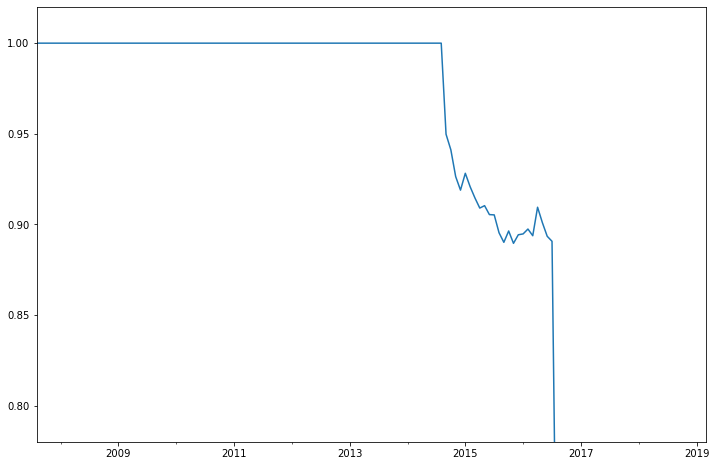

In [27]:
ax = pd.Series(doneness_dict).plot(figsize=(12,8))
ax.set_ylim(.78, 1.02)

In [28]:
doneness_df = pd.DataFrame({'n_issued': issuances_dict, 'pct_doneness_thrsh': doneness_dict})

In [31]:
doneness_df[doneness_df['pct_doneness_thrsh'] > .8]

,n_issued,pct_doneness_thrsh
2007-08-01,21,1.000000
2007-09-01,50,1.000000
2007-10-01,103,1.000000
2007-11-01,112,1.000000
2007-12-01,172,1.000000
2008-01-01,305,1.000000
2008-02-01,306,1.000000
2008-03-01,402,1.000000
2008-04-01,259,1.000000
2008-05-01,115,1.000000


# done deciding

In [32]:
#from 2010-1-1 onward, take out min(10%, 2000) loans to set aside as train

In [55]:
doneness = .95
train_testable_eval_loan_info = eval_loan_info.query('maturity_time_stat_adj >= @doneness or maturity_paid_stat_adj >= @doneness')
train_testable_ids = train_testable_eval_loan_info['id']
train_testable_loan_info = base_loan_info.query('id in @train_testable_ids')

assert train_testable_eval_loan_info.shape[0] == train_testable_loan_info.shape[0]

train_testable_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_testable_eval_loan_info.fth'))
train_testable_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_testable_loan_info.fth'))

In [76]:
train_testable_eval_loan_info = pd.read_feather(os.path.join(dpath, 'train_testable_eval_loan_info.fth'))
train_testable_loan_info = pd.read_feather(os.path.join(dpath, 'train_testable_loan_info.fth'))

In [77]:
issue_d_g = train_testable_eval_loan_info.groupby('issue_d')

In [101]:
test_ids = []
for date, group in issue_d_g:
    if date >= pd.to_datetime('2010-1-1'):
        test_ids.extend(group.sample(n = min(int(len(group)*.1), 2000))['id'].tolist())

In [107]:
test_eval_loan_info = train_testable_eval_loan_info.query('id in @test_ids')
test_loan_info = train_testable_loan_info.query('id in @test_ids')

train_eval_loan_info = train_testable_eval_loan_info.query('id not in @test_ids')
train_loan_info = train_testable_loan_info.query('id not in @test_ids')

In [126]:
def check_not_same_loans(tr, te, to):
    if len(set(tr['id']).intersection(set(te['id']))) == 0: return True
    else: return False
    
def check_all_loans_accounted(tr, te, to):
    if tr.shape[0] + te.shape[0] == to.shape[0]: return True
    else: return False
    
def check_same_n_instances(df1, df2):
    if df1.shape[0] == df2.shape[0]: return True
    else: return False
    
def check_same_n_cols(df1, df2):
    if df1.shape[1] == df2.shape[1]: return True
    else: return False    
    
def check_train_test_testable(train, test, testable, train1, test1, testable1):
    '''
    First set for loan_info, second set for eval_loan_info
    '''
    print(train.shape, test.shape, testable.shape, train1.shape, test1.shape, testable1.shape)
    assert check_not_same_loans(train, test, testable)
    assert check_all_loans_accounted(train, test , testable)
    assert check_not_same_loans(train1, test1, testable1)
    assert check_all_loans_accounted(train1, test1 , testable1)
    assert check_same_n_instances(train, train1)
    assert check_same_n_instances(test, test1)
    assert check_same_n_instances(testable, testable1)
    assert check_same_n_cols(train, test)
    assert check_same_n_cols(train1, test1)
    return True

In [127]:
check_train_test_testable(train_eval_loan_info, test_eval_loan_info, train_testable_eval_loan_info,
                          train_loan_info, test_loan_info, train_testable_loan_info)

(1354333, 46) (118856, 46) (1473189, 46) (1354333, 103) (118856, 103) (1473189, 103)


True

In [130]:
# save
test_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'test_eval_loan_info.fth'))
test_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'test_loan_info.fth'))
train_eval_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_eval_loan_info.fth'))
train_loan_info.reset_index(drop=True).to_feather(os.path.join(dpath, 'train_loan_info.fth'))

In [148]:
# make 10 bootstrap month-by-month test_loan_infos (and maybe test_eval_loan_infos?)
issue_d_g = test_eval_loan_info.groupby('issue_d')
for i in range(10):
    to_concat = []
    for d, g in issue_d_g:
        to_concat.append(g.sample(len(g), replace=True))
    df = pd.concat(to_concat)
    df.reset_index(drop=True).to_feather(os.path.join(dpath, 'test_eval_loan_info_{0}_bootstrap.fth'.format(i)))

In [150]:
ls {dpath}

base_loan_info.fth*              test_eval_loan_info_0_bootstrap.fth
bsmbm_top30_df.csv               test_eval_loan_info_1_bootstrap.fth
clean_pmt_history_1.fth*         test_eval_loan_info_2_bootstrap.fth
clean_pmt_history_2.fth*         test_eval_loan_info_3_bootstrap.fth
clean_pmt_history_3.fth*         test_eval_loan_info_4_bootstrap.fth
csvs/                            test_eval_loan_info_5_bootstrap.fth
eval_loan_info.fth*              test_eval_loan_info_6_bootstrap.fth
example.py*                      test_eval_loan_info_7_bootstrap.fth
loan_info_api_name_matched.fth*  test_eval_loan_info_8_bootstrap.fth
loan_info.fth*                   test_eval_loan_info_9_bootstrap.fth
mbm_top30_df.csv                 test_eval_loan_info.fth
model_returns_dict.pkl           test_loan_info.fth
npv_roi_df.fth                   train_eval_loan_info.fth
raw_loan_info.fth*               train_loan_info.fth
scaled_pmt_hist.fth*             train_testable_eval_loan_info.fth
strings_loan_info_df.ft